# ROS VISUALIZATIONS

In this document we will see the visualization of the ROS implementation of an IBVS system. In order to visualize the system, the VisualServo functions of plotting
the history parameters of the system are adapted. For that, we created three history documents of the ibvs parameters.

## Instructions
This notebook contains all the commands necessary to run the the IBVS Ros System. However some steps have to be done.
1. Place the "ibvs" folder in the "src" folder of your ROS workspace.
2. Modify the path of the "src" folder of the next cell, in order to compile the ROS workspace and execute the IBVS system.

In [6]:
ws_path = '/home/pablo/ros2_iron/src'

import subprocess
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [10]:
# Here we are going to define the commands to initialize the IBVS Ros System
def build_ros2_package(package_name, ws_path):
    try:
        result = subprocess.run(
            ['colcon', 'build', '--packages-select', package_name],
            cwd=ws_path,  # Update this path if your workspace is different
            check=True,
            text=True,
            capture_output=True
        )
        print(result.stdout)
        print(result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while building the package: {e}")

def source_and_launch(workspace_dir, package_name, launch_file):
    try:
        # Combine sourcing and launching into one bash command
        command = f'''
        source {workspace_dir}/install/setup.bash
        ros2 launch {package_name} {launch_file}
        '''
        result = subprocess.run(
            ['bash', '-c', command],
            cwd=workspace_dir,
            check=True,
            text=True
        )
        print(result.stdout)
        print(result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while sourcing and launching: {e}")

In [16]:
build_ros2_package('ibvs', ws_path)
source_and_launch(ws_path, 'ibvs', 'launch.py')

Starting >>> ibvs
[Processing: ibvs]
Finished <<< ibvs [50.8s]

Summary: 1 package finished [52.3s]


[INFO] [launch]: All log files can be found below /home/pablo/.ros/log/2024-07-09-14-26-50-458911-DESKTOP-8TLR9V5-92829
[INFO] [launch]: Default logging verbosity is set to INFO
[INFO] [actuator-1]: process started with pid [92895]
[INFO] [controller-2]: process started with pid [92897]
[INFO] [feature_extractor-3]: process started with pid [92899]
[controller-2] [INFO] [1720528021.626572002] [controller]: lambda: 0.05
[controller-2] [INFO] [1720528021.627281402] [controller]: eterm: 1e-06
[controller-2] [INFO] [1720528022.418384495] [controller]: Received uv: "std_msgs.msg.Float64MultiArray(layout=std_msgs.msg.MultiArrayLayout(dim=[std_msgs.msg.MultiArrayDimension(label='', size=2, stride=0), std_msgs.msg.MultiArrayDimension(label='', size=4, stride=0)], data_offset=0), data=[222.00438233905726, 267.1757802106601, 333.20262940343434, 288.0312315318315, 447.8613716970714, 513.888220889

In [17]:
# Load history of the IBVS system
uv = np.load('uv.npy') # Image coordinates
poses = np.load('c_pose_history.npy') # Camera poses
velocities = np.load('v.npy') # Camera Velocities

In [18]:
def plot_feature_trajectory(uv, c_pose, vel):
    """
    Plot feature trajectory from simulation

    Show image feature points versus time.

    :param uv: A numpy array of shape (107, 2, 4) representing the history of uv points.
    :param c_pose: A numpy array of shape (106, 4, 4) representing the history of camera poses.
    :param vel: A numpy array of shape (107, 6) representing the history of camera velocities.
    """
    n_points = uv.shape[2]
    n_timesteps = uv.shape[0]
    
    # Plot the trajectory of each feature point
    for i in range(n_points):
        u = uv[:, 0, i]
        v = uv[:, 1, i]
        plt.plot(u, v, "b", label="Trajectory" if i == 0 else "")
    
    # Mark the initial target shape
    initial_uv = uv[0]
    plt.plot(initial_uv[0, :], initial_uv[1, :], 'o--', markeredgecolor="k", markerfacecolor="w", label="Initial")

    # Mark the goal target shape (last uv position)
    final_uv = uv[-1]
    plt.plot(final_uv[0, :], final_uv[1, :], 'k*:', markeredgecolor="k", markerfacecolor="k", label="Goal")

    plt.grid(True)
    plt.xlabel("u (pixels)")
    plt.ylabel("v (pixels)")
    plt.xlim(0, 1000)  # Adjust based on your camera's resolution
    plt.ylim(0, 1000)  # Adjust based on your camera's resolution
    plt.legend()
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_facecolor("lightyellow")
    plt.title("Feature Trajectory from Simulation")
    plt.show()

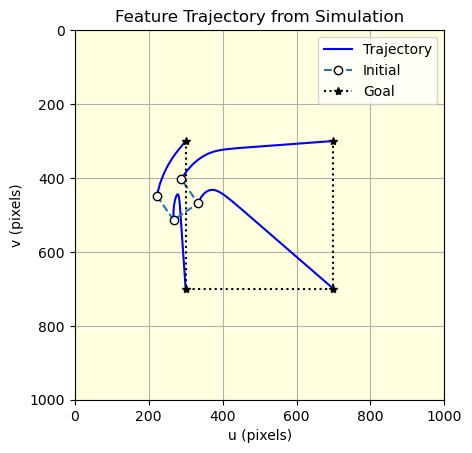

In [19]:
plot_feature_trajectory(uv, poses, velocities)

In [20]:
def plot_vel(vel_history):
    """
    Plot camera velocity from simulation

    Show camera velocity versus time.

    :param vel_history: numpy array of camera velocities with shape (107, 6)
    """
    if len(vel_history) == 0:
        return

    vel = np.array(vel_history)
    plt.plot(vel[:, :3], "-")
    plt.plot(vel[:, 3:], "--")
    plt.ylabel("Cartesian velocity")
    plt.grid(True)
    plt.xlabel("Time step")
    plt.xlim(0, len(vel_history) - 1)
    plt.legend(
        ["$v_x$", "$v_y$", "$v_z$", r"$\omega_x$", r"$\omega_y$", r"$\omega_z$"],
        loc="upper right",
    )
    plt.title("Camera Velocity vs Time")
    plt.show()

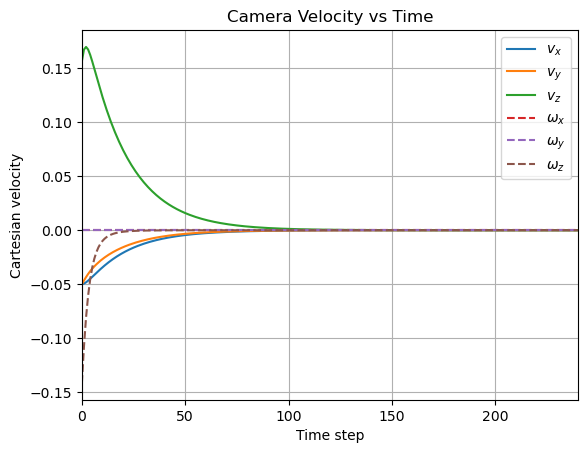

In [21]:
plot_vel(velocities)

In [22]:

def plot_pose(c_pose_history):
    """
    Plot camera trajectory from simulation

    Show camera pose versus time, as two plots: translation and rotation
    in RPY angles.

    :seealso: :meth:`plot_p` :meth:`self.plot_vel` :meth:`plot_jcond` :meth:`plot_z` :meth:`plot_error`
    """

    if len(c_pose_history) == 0:
        return

    # Extract translations (x, y, z) and rotations (RPY) from the c_pose history
    translations = np.array([pose[:3, 3] for pose in c_pose_history])
    rotations = np.array([R.from_matrix(pose[:3, :3]).as_euler('xyz', degrees=False) for pose in c_pose_history])

    plt.figure(figsize=(12, 6))

    # Cartesian camera position vs timestep
    plt.subplot(211)
    plt.plot(translations)
    plt.xlim(0, len(c_pose_history) - 1)
    plt.ylabel("Camera position (m)")
    plt.legend(["x", "y", "z"])
    plt.grid(True)

    # Camera orientation (RPY) vs timestep
    plt.subplot(212)
    plt.plot(rotations)
    plt.ylabel("Camera orientation (rad)")
    plt.xlabel("Time step")
    plt.xlim(0, len(c_pose_history) - 1)
    plt.legend([r"$\alpha$", r"$\beta$", r"$\gamma$"])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

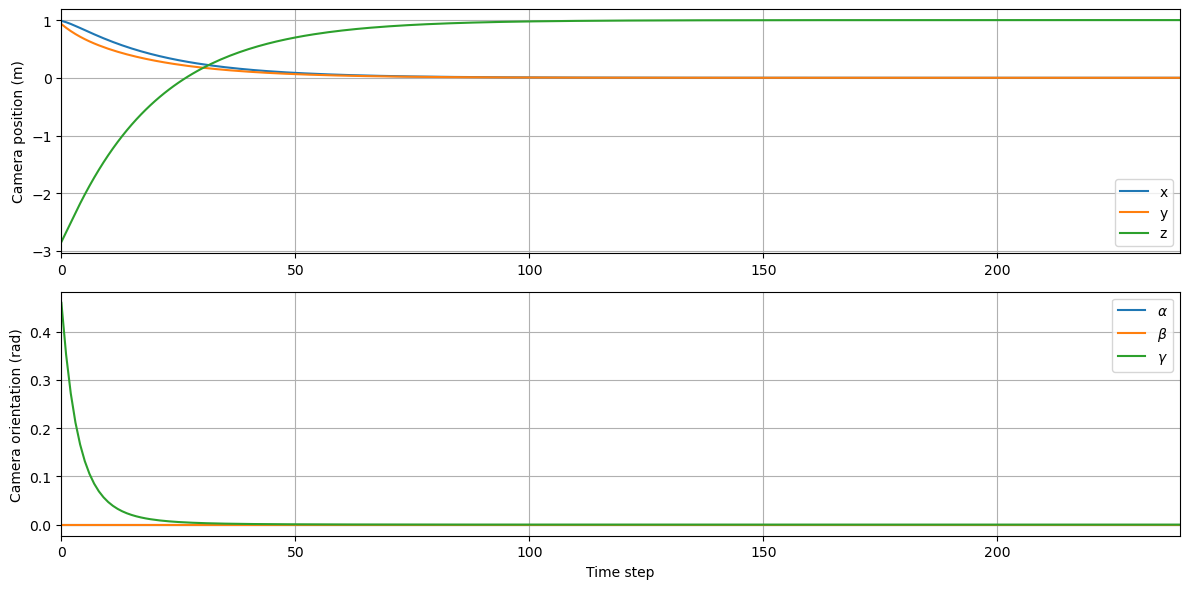

In [23]:
plot_pose(poses)